In [ ]:
## ---------- ##
# Environment #
## ---------- ##

import os
cwd = os.getcwd()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import tensorflow as tf
import numpy as np

# SEED experiments are to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

# Access to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image Segmentation ACRE
## Build dataset

In [ ]:
# ------------------ #
# ImageDataGenerator
# ------------------ #
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen = ImageDataGenerator(rotation_range=90,
                                      width_shift_range=0.4,
                                      height_shift_range=0.4,
                                      zoom_range=0.6,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect',
                                      brightness_range =[0.8,1.2])
mask_data_gen = ImageDataGenerator(rotation_range=90,
                                       width_shift_range=0.4,
                                       height_shift_range=0.4,
                                       zoom_range=0.6,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [ ]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None,validation_part=0.2,out_shape=[512,512],projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Haricot','Mais']):
    
    # ---------- #
    # Attributs  #
    # ---------- #

    self.png_or_jpg = []
    self.subset_filenames = []
    self.subset_direc = []

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    
    for project in projects :
      for plant in plants :
        path = os.path.join(dataset_dir,project,plant)
        list_ = os.listdir(os.path.join(path,'Images')) 
        number_files = len(list_)
        training_num_max = int(number_files - int(number_files *  (1 - validation_part)))
        
        # ----- Training set  ----- #

        if which_subset == 'training':
          number_max = training_num_max
          for ii in range(0,number_max):
            self.subset_filenames.append(os.path.splitext(list_[ii])[0])
            self.subset_direc.append(path)

            if project!='Roseau': # Roseau has images and masks as png.
              self.png_or_jpg.append(1)
            else:
              self.png_or_jpg.append(0)

        # ----- Validation set  ----- #
              
        elif which_subset == 'validation':
          number_max = number_files - training_num_max
          for ii in range(number_files - 1, number_files - number_max, -1):
            self.subset_filenames.append(os.path.splitext(list_[ii])[0])
            self.subset_direc.append(path)
            if project!='Roseau':
              self.png_or_jpg.append(1)
            else:
              self.png_or_jpg.append(0)
            

  def __len__(self):
    return len(self.subset_filenames)

  
  def __getitem__(self, index):
    
    #Read files (image and target)
    curr_filename = self.subset_filenames[index]
    curr_dir = self.subset_direc[index]
    
    if self.png_or_jpg[index] != 0:
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.jpg'))
    else:
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.png'))
    
    mask = Image.open(os.path.join(curr_dir, 'Masks', curr_filename + '.png'))

    # Resize 
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)

    mask_arr = np.array(mask)
    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
    
    img_arr = np.array(img)
    mask_arr = new_mask_arr
    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        
        # Perform data augmentation
        
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    img_arr=1./255*img_arr
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(255*img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
path = '/content/drive/MyDrive/Keras_Tutorial_4/Development_Dataset/Training/'
val_part = 0.2

dataset = CustomDataset(path, 'training', 
                        img_generator=img_data_gen, 
                        mask_generator=mask_data_gen,
                        preprocessing_function=None,
                        validation_part=val_part,
                        projects=['Weedelec','Pead','Roseau','Bipbip'],
                        plants=['Mais','Haricot'])
dataset_valid = CustomDataset(path, 'validation', 
                            preprocessing_function=None,
                            validation_part=val_part,
                            projects=['Roseau'],
                            plants=['Mais','Haricot'])


In [ ]:
img_h = 512#256
img_w = 512#256
bs = 10

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w,1]))
valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

In [ ]:
# ---------------------------- #
# Test of the dataset creation
# ---------------------------- #

import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 2)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(train_dataset)

[0. 1. 2.]


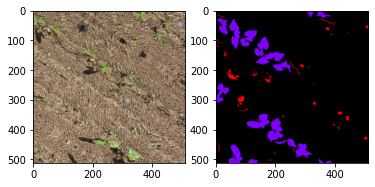

In [ ]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[1]   # First element
augmented_img = 255*augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

## Network for image classifaction
### Encoder -Decoder

In [ ]:
def create_model(start_f):
  input_shape = [img_h, img_w, 3]
  inputs = tf.keras.Input(shape=(img_h, img_w, 3))
  x_1_1 = tf.keras.layers.Conv2D(filters = start_f, 
                                kernel_size = (2,2),
                                strides=(1, 1),
                                padding='same')(inputs)
  x_1_1 = tf.keras.layers.Conv2D(filters = start_f, 
                                kernel_size = (2,2),
                                strides=(1, 1),
                                padding='same')(x_1_1)                              
  x_1_2 = tf.keras.layers.Conv2D(filters = start_f, 
                                kernel_size = (3,3),
                                strides=(1, 1),
                                padding='same')(inputs)
  x_1_2 = tf.keras.layers.Conv2D(filters = start_f, 
                                kernel_size = (3,3),
                                strides=(1, 1),
                                padding='same')(x_1_2)
  x_1 = tf.keras.layers.Average()([x_1_1, x_1_2])
  input_shape = None


  start_f *= 2
  x_1 = tf.keras.layers.BatchNormalization(axis=-1)(x_1)
  x_1  = tf.keras.layers.Activation('relu')(x_1)
  x_2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x_1)
  x_2_1 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(2, 2),
                      strides = (1,1),
                      padding = 'same')(x_2)
  x_2_1 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(2, 2),
                      strides = (1,1),
                      padding = 'same')(x_2_1)
 
  x_2_2 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x_2)
  x_2_2 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(2, 2),
                      strides = (1,1),
                      padding = 'same')(x_2_2)

  x_2 = tf.keras.layers.Average()([x_2_1, x_2_2])
  x_2 = tf.keras.layers.BatchNormalization(axis=-1)(x_2)
  x_2 = tf.keras.layers.Activation('relu')(x_2)
  x_3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x_2)



  start_f *= 2
  x_3_1 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(2, 2),
                      strides = (1,1),
                      padding = 'same')(x_3)
  x_3_1 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(2, 2),
                      strides = (1,1),
                      padding = 'same')(x_3_1)
  x_3_2 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x_3)
  x_3_2 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x_3_2)

  x_3 = tf.keras.layers.Average()([x_3_1, x_3_1])
  x_3 = tf.keras.layers.BatchNormalization(axis=-1)(x_3)
  x_3 = tf.keras.layers.Activation('relu')(x_3)
  x_4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x_3)


  start_f *= 2
  x_4_1 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(2, 2),
                      strides = (1,1),
                      padding = 'same')(x_4)
  x_4_1 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(2, 2),
                      strides = (1,1),
                      padding = 'same')(x_4_1)
  x_4_2 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x_4)
  x_4_2 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x_4_2)

  x_4 = tf.keras.layers.Average()([x_4_1, x_4_2])
  x_4 = tf.keras.layers.BatchNormalization(axis=-1)(x_4)
  x_4 = tf.keras.layers.Activation('relu')(x_4)
  x_5 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x_4)

  start_f *= 2
  x_5_1 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(2, 2),
                      strides = (1,1),
                      padding = 'same')(x_5)
  x_5_1 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(2, 2),
                      strides = (1,1),
                      padding = 'same')(x_5_1)
  x_5_2 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x_5)
  x_5_2 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x_5_2)
 
  x_5 = tf.keras.layers.Average()([x_5_1, x_5_2])
  x_5 = tf.keras.layers.BatchNormalization(axis=-1)(x_5)
  x_5 = tf.keras.layers.Activation('relu')(x_5)



  #MIDDLE BLOCK
  m = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x_5)
  m = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(m)
  
  m = tf.keras.layers.BatchNormalization(axis=-1)(m)
  m = tf.keras.layers.Activation('relu')(m)

  #DECODER
  start_f = start_f // 2
  y_1_1 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(2,2), strides=(2, 2), padding='same')(m)
  y_1_1 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(2,2), strides=(1, 1), padding='same')(y_1_1)
  y_1_2 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(2, 2), padding='same')(m)
  y_1_2 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(1,1), padding='same')(y_1_2)
  y_1 = tf.keras.layers.Average()([y_1_1, y_1_2])
  y_1 = tf.keras.layers.ReLU()(y_1)
  y_1 = tf.keras.layers.Add()([y_1,x_4])

  start_f = start_f // 2
  y_2_1 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(2,2), strides=(2, 2), padding='same')(y_1)
  y_2_1 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(2,2), strides=(1, 1), padding='same')(y_2_1)
  y_2_2 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(2, 2), padding='same')(y_1)
  y_2_2 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(1, 1), padding='same')(y_2_2)
  y_2 = tf.keras.layers.Average()([y_2_1, y_2_2])
  y_2 = tf.keras.layers.ReLU()(y_2)
  y_2 = tf.keras.layers.Add()([y_2,x_3])


  start_f = start_f // 2
  y_3_1 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(2,2), strides=(2, 2), padding='same')(y_2)
  y_3_1 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(2,2), strides=(1, 1), padding='same')(y_3_1)
  y_3_2 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(2, 2), padding='same')(y_2)
  y_3_2 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(1, 1), padding='same')(y_3_2)
  y_3 = tf.keras.layers.Average()([y_3_1, y_3_2])
  y_3 = tf.keras.layers.ReLU()(y_3)
  y_3 = tf.keras.layers.Add()([y_3,x_2])

  start_f = start_f // 2
  y_4_1 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(2,2), strides=(2, 2), padding='same')(y_3)
  y_4_1 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(2,2), strides=(1, 1), padding='same')(y_4_1)
  y_4_2 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(2, 2), padding='same')(y_3)
  y_4_2 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(1,1), padding='same')(y_4_2)
  y_4 = tf.keras.layers.Average()([y_4_1, y_4_2])
  y_4 = tf.keras.layers.ReLU()(y_4)
  y_4 = tf.keras.layers.Add()([y_4,x_1])
  y_4 = tf.keras.layers.Dropout(0.4, seed=SEED)(y_4)


  
  last = tf.keras.layers.Conv2D(filters=3,
                                kernel_size=(1, 1),
                                strides=(1, 1),
                                padding='same',
                                activation='softmax')(y_4)
  model_1 = tf.keras.Model(inputs=inputs, outputs=last)
  print("first model summary")
  model_1.summary()

  return model_1

In [ ]:
model=create_model(start_f=50)

# Model summary
model.summary()

# Weights summary
# model.weights

first model summary
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 50) 650         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 50) 1400        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 50) 10050       conv2d[0][0]                     
__________________________________________________________________________

## Prepare the model for training

In [ ]:
# ---------------------------- #
#    Optimization parameters   #
# ---------------------------- #

# Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# Learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)


# Metric for image segmentation 

def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
    
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# ------------------- #
#  Validation metrics #
# ------------------- #

metrics = [ meanIoU,'accuracy']

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training with callbacks

In [ ]:
callbacks = []

early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    callbacks.append(es_callback)


history=model.fit(x=train_dataset,
          epochs=15,  
          steps_per_epoch=400,
          validation_data=valid_dataset,
          validation_steps=80, 
          callbacks=callbacks)

Epoch 1/15
400/400 [==============================] - 2643s 7s/step - loss: 0.3080 - meanIoU: 0.1853 - accuracy: 0.8858 - val_loss: 0.7788 - val_meanIoU: 1.8092e-05 - val_accuracy: 0.9095
Epoch 2/15
400/400 [==============================] - 2507s 6s/step - loss: 0.0795 - meanIoU: 0.3208 - accuracy: 0.9739 - val_loss: 0.2547 - val_meanIoU: 0.2077 - val_accuracy: 0.9334
Epoch 3/15
400/400 [==============================] - 2493s 6s/step - loss: 0.0698 - meanIoU: 0.3358 - accuracy: 0.9762 - val_loss: 0.5445 - val_meanIoU: 0.0610 - val_accuracy: 0.9146
Epoch 4/15
400/400 [==============================] - 2475s 6s/step - loss: 0.0639 - meanIoU: 0.3827 - accuracy: 0.9774 - val_loss: 0.3047 - val_meanIoU: 0.2169 - val_accuracy: 0.9327
Epoch 5/15
400/400 [==============================] - 2472s 6s/step - loss: 0.0594 - meanIoU: 0.4507 - accuracy: 0.9785 - val_loss: 0.4775 - val_meanIoU: 0.1342 - val_accuracy: 0.9208
Epoch 6/15
400/400 [==============================] - 2516s 6s/step - loss: 

In [ ]:
#------------------------------
#       MODEL SAVING
#------------------------------

out = '/content/drive/My Drive/Keras_Tutorial_4/models/'



model_name = 'Roseau_specific_last'

model.save(out + '/' + model_name  + '.h5')
model.save_weights(out + '/weights_' + model_name)

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for meanIoU
plt.plot(history.history['meanIoU'])
plt.plot(history.history['val_meanIoU'])
plt.title('model meanIoU')
plt.ylabel('meanIoU')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()